# Implementing Portfolio Insurance(CPPI) and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import risk_kit as rk
import numpy as np
import pandas as pd

ind_return = rk.get_ind_returns()
tmi_return = rk.get_total_market_index_return()

In [3]:
# risky return
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]

# safe return
safe_r = pd.DataFrame().reindex_like(risky_r)

In [6]:
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

1. Cushion - (Asset Value minus Floor Value)
2. Compute an Allocation to Safe and Risky Assets --> m*risk_budget
3. Recompute the Asset Value based on the Returns

In [54]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # update the account value for this time stamp
    account_value = risky_alloc * (1+risky_r.iloc[step]) + safe_alloc * (1+safe_r.iloc[step])
    # save the values
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value

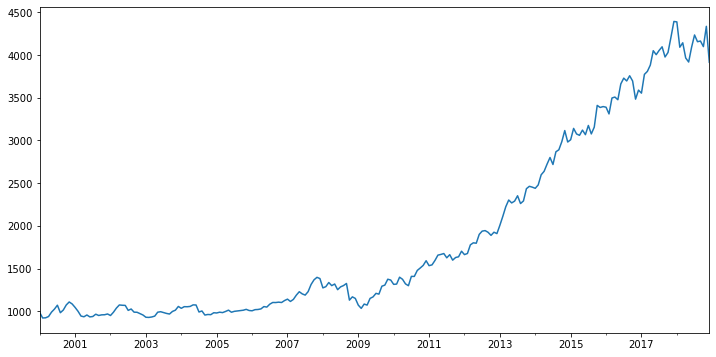

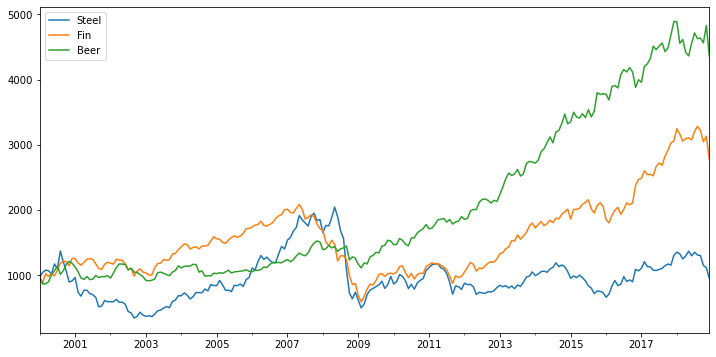

In [55]:
risky_wealth = start*(1+risky_r).cumprod()
account_history["Beer"].plot(figsize=(12,6))
risky_wealth.plot(figsize=(12,6))

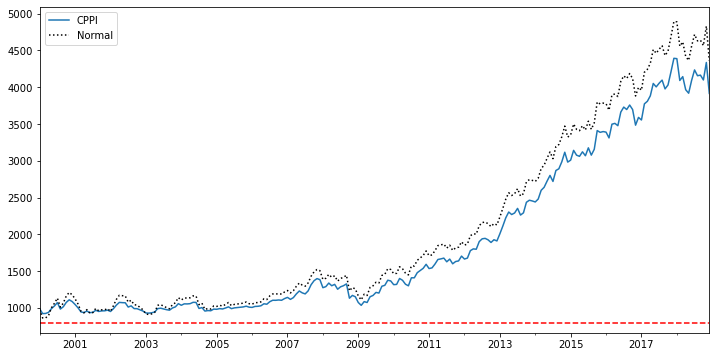

In [59]:
ax = account_history["Beer"].plot(figsize=(12,6), label="CPPI", legend=True)
risky_wealth["Beer"].plot(ax=ax, style="k:", label="Normal", legend=True)
ax.axhline(y=floor_value, color='r', linestyle = "--")

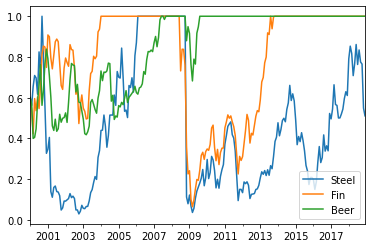

In [60]:
risky_w_history.plot()

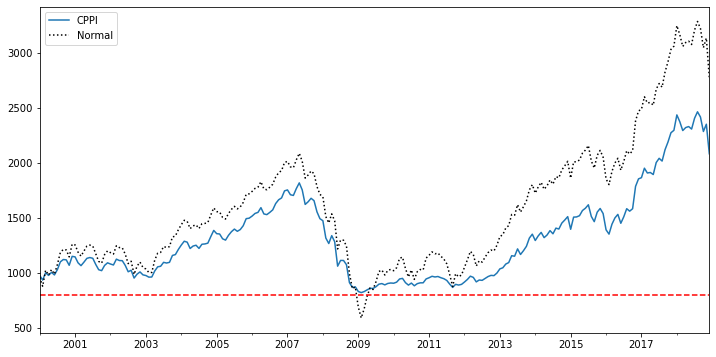

In [61]:
ax = account_history["Fin"].plot(figsize=(12,6), label="CPPI", legend=True)
risky_wealth["Fin"].plot(ax=ax, style="k:", label="Normal", legend=True)
ax.axhline(y=floor_value, color='r', linestyle = "--")

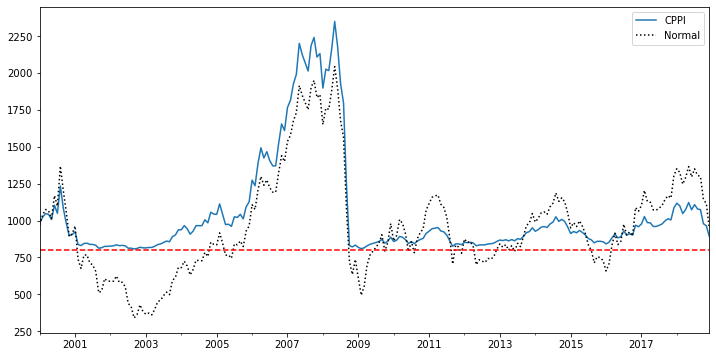

In [65]:
ax = account_history["Steel"].plot(figsize=(12,6), label="CPPI", legend=True)
risky_wealth["Steel"].plot(ax=ax, style="k:", label="Normal", legend=True)
ax.axhline(y=floor_value, color='r', linestyle = "--")

In [66]:
rk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [69]:
btr = rk.run_cppi(risky_r)
rk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


In [71]:
btr = rk.run_cppi(tmi_return["2007":])

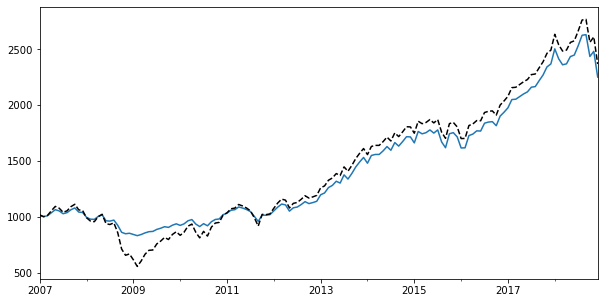

In [79]:
ax = btr["Wealth"].plot(figsize=(10,5), legend=False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend=False)

In [76]:
rk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [80]:
# Drawdown Constraint

In [85]:
btr = rk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)

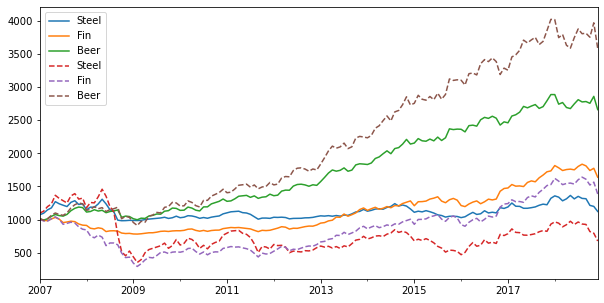

In [88]:
ax = btr["Wealth"].plot(figsize=(10,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [89]:
rk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [90]:
rk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
